In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.visualize as visualize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import petab
import numpy as np
from scipy import integrate
from scipy.special import gammaln
from scipy.special import gamma
import pickle

datatype = "original"

# import to petab
if datatype == "original":
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_original.yaml")
elif datatype == "switch":
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_switch.yaml")
else:
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_loss.yaml")

In [2]:
dataframe = pd.read_csv("data/SS_measurements_scaling.tsv", sep = "\t")

In [3]:
def analytical_b(t, a0, b0, k1, k2):
    return (k2 - k2 * np.exp(-(k2 + k1) * t)) / (k2 + k1)

def simulate_model(x, tvec):
    # assign parameters
    k1, k2 = x
    
    # define initial conditions
    a0 = 1
    b0 = 0
    # simulate model
    simulation = [analytical_b(t, a0, b0, k1, k2)
                   for t in tvec]
    return simulation

After importing the model, we need to define the objective function. This time we will do it via an external function that will be used then by pyPESTO instead of using the built-in ones.

For numerical reasons we will implement the log likelihood and log prior.

In [4]:
def negative_log_marginalised_posterior(x):
    """ Negative log posterior function."""

#     shape = x[-1]
    shape = 0.3684

    # experimental data
    data = np.array(dataframe.measurement)
    # time vector
    tvec = np.array(dataframe.time)

    N = len(tvec)

    # simulate model
    simulation = simulate_model(np.exp(x), tvec)
    
    
    #we need now to sort the b-vector by size, remove the values for simulation = 0 and then apply
    #this order to the data and simulation as well
    
    #we devide by the accordng values and set -1 where simulation would be 0
    b_vector_us = np.divide(data, simulation, out = -np.ones(N), where=simulation!=0)
    #now these values are at the start and the rest is sorted
    b_vector_l = np.sort(b_vector_us)
    #we safe the order
    sort_order = np.searchsorted(b_vector_l, b_vector_us)
    #and determine how many simulation avlues are 0
    zero_amnt = np.argmax(b_vector_l > -1)
    #they get removed from the b vector
    b_vector = b_vector_l[zero_amnt:]
    
    #N' is the amount of integral breaks
    N_prime = N - zero_amnt
    #we need only N values in the end but add soem spaces for convenience later
    data_sorted = np.ones(N + zero_amnt) - 2
    simulation_sorted = np.ones(N + zero_amnt) - 2
    
    for i in range(N):
        # in case that several values in b_vector have the same value
        j = 0 
        while simulation_sorted[sort_order[i] + j] != -1:
            j += 1
            
        simulation_sorted[sort_order[i] + j] = simulation[i]
        data_sorted[sort_order[i] + j] = data[i]
        
        
    for i in range(zero_amnt):
        data_sorted[N + i] = data_sorted[i]
        simulation_sorted[N + i] = simulation_sorted[i]
        
    data_sorted = data_sorted[zero_amnt:]
    simulation_sorted = simulation_sorted[zero_amnt:]
    
    bounds = np.append(np.append(0, b_vector), np.inf)
    
    d_vector = -np.sum(data_sorted)
    # we can just sum up the whole array because values >= N' are 0 by construction
    q_vector = np.sum(simulation_sorted)
    
    l_llh = 0
    const = lamda*shape
    check = q_vector - const
    
    for i in range(N_prime):
        
        if check != 0:
            aux1 = (shape / check)
            aux2 = np.exp((d_vector + bounds[i + 1] * check) / shape) \
                -  np.exp((d_vector + bounds[i] * check) / shape)
        else:
            aux1 = np.exp(d_vector / shape)
            aux2 = bounds[i + 1] - bounds[i]
        
        l_llh += aux1 * aux2
        d_vector = d_vector + 2*data_sorted[i]
        q_vector = q_vector - 2*simulation_sorted[i]
        check = q_vector - const
        
    l_llh = l_llh - (shape / check) * np.exp((d_vector + bounds[N_prime] * check) / shape)
    
    
    
    # return NEGATIVE log posterior (required for pyPESTO)
    
    
    return -(np.log(lamda) - N*(np.log(2) + np.log(shape)) + np.log(l_llh))

In [5]:
def posterior(scale, data, simulation):
    """ Negative log posterior function."""

    N = len(data)
    
    shape = 0.3684

    diff = -abs(data - scale*simulation) / shape
    factor1 = np.prod(np.exp(diff))
    factor2 = 1 / ((2 * shape)**N)

    llh = factor1 * factor2
    prior = lamda * np.exp(-lamda * scale)

    return llh * prior

def numerical_log_post( data, simulation):
    numerical_value, _ = integrate.quad(posterior, 0, np.inf, args=(data, simulation))

    return np.log(numerical_value)

In [6]:
data = np.array(dataframe.measurement)
tvec = np.array(dataframe.time)
x0 = np.array([-1.2741, -0.6160])
# x0 = np.array([-1.2741, 0.3684])

lamda = 0.01

approx_data = np.asarray(simulate_model(np.exp(x0), tvec))
analyt = -negative_log_marginalised_posterior(x0)
num = numerical_log_post(data, approx_data)
print(num)
print(analyt)

-3.5211088153741503
-3.5211087958667022


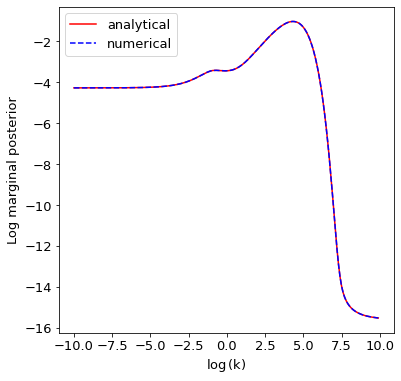

In [7]:
from copy import deepcopy

num_values = []
analyt_values = []

lamda = 0.01

k_values = np.arange(-10, 10, 0.1)

for k in k_values:
    k_vector = deepcopy(x0)
    k_vector[0] = k
    
    approx_data = np.asarray(simulate_model(np.exp(k_vector), tvec))
    num = numerical_log_post(data, approx_data)
    num_values.append(num)
    
    analyt = -negative_log_marginalised_posterior(k_vector)
    analyt_values.append(analyt)
    
num_values = np.asarray(num_values)
analyt_values = np.asarray(analyt_values)

plt.figure(figsize=(6,6))
plt.plot(k_values,analyt_values,'r-',label='analytical')
plt.plot(k_values,num_values,'b--',label='numerical')
plt.xlabel(r'$\log$(k)',fontsize=13)
plt.ylabel('Log marginal posterior',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.show()

Now that we have the objective function defined, we need to create a pyPESTO problem.

In [8]:
def marginal_sampling():
    """Creates a pyPESTO problem."""
    objective = pypesto.Objective(fun=negative_log_marginalised_posterior)
    problem = pypesto.Problem(objective=objective,  # objective function
                              lb=[-5, -5],  # lower bounds
                              ub=[5, 5],  # upper bounds
                              x_names=['k1', 'k2'],  # parameter names
                              x_scales=['log', 'log'])  # parameter scale
    return problem

In [9]:
### Prior dependent paramters
lamda = 0.1

# create the estimation problem
problem = marginal_sampling()

# MCMC chain length
n_samples= 1e5

x0 = np.array([-1.2741, -0.6160])

# call the sampler of choice
sampler = sample.AdaptiveMetropolisSampler()

In [10]:
# Define number of runs
runs = 1
save_results = False # for testing just set to False

lamda = 20

# Loop over n runs
for n in range(runs):
    # set initial random seed
    np.random.seed(n)
    # perform MCMC sampling
    result = sample.sample(problem, n_samples=n_samples, sampler=sampler,
                           x0=x0)
    # calculate effective sample size
    sample.effective_sample_size(result=result)

    # save the results as a pickle object
    if save_results:
        results = result.sample_result
        with open('Results/Full_parameter/' + str(n) + '.pickle','wb') as result_file:
            pickle.dump(results, result_file, n)

100%|██████████| 100000/100000 [00:36<00:00, 2705.67it/s]
Elapsed time: 37.216454014
Geweke burn-in index: 0
Estimated chain autocorrelation: 11.381545094769145
Estimated effective sample size: 8076.617193943559


There are some built-in visualization functions that one can use.

8076.617193943559
217.01737599464246


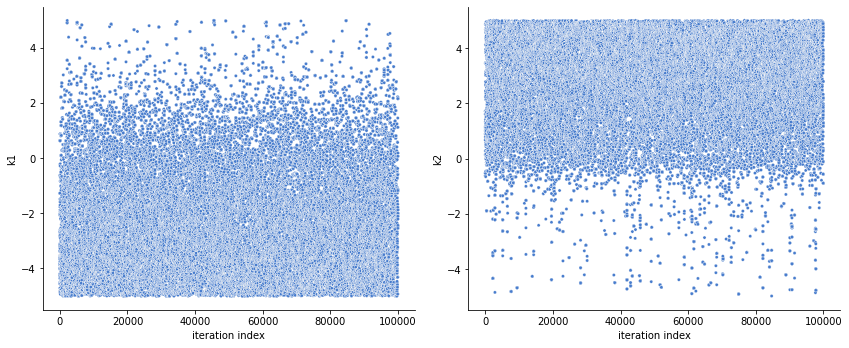

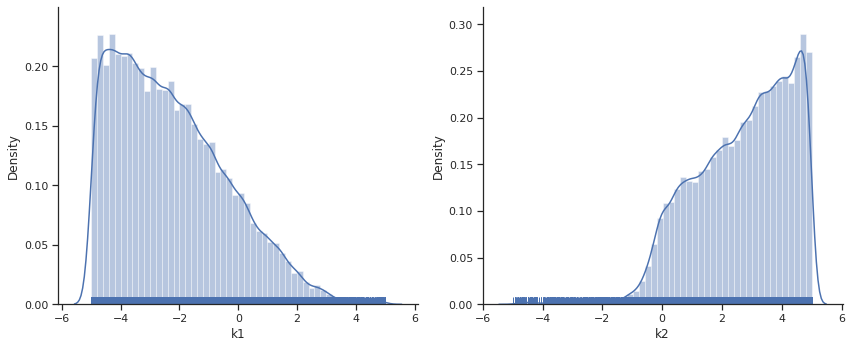

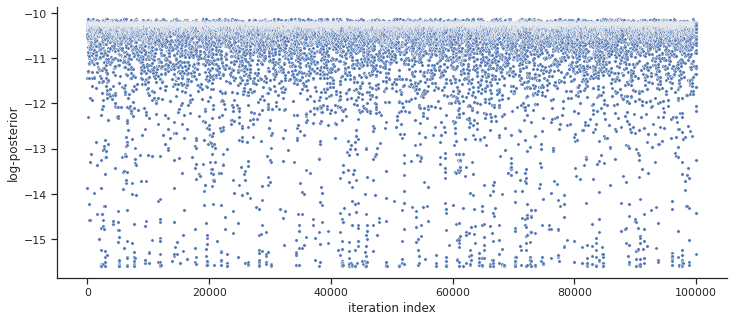

In [11]:
print(result.sample_result.effective_sample_size)
print(result.sample_result.effective_sample_size/result.sample_result.time)

# result.sample_result.burn_in = 5000
# Visualize the parameter trace
ax = visualize.sampling.sampling_parameters_trace(result, use_problem_bounds=False, full_trace=True, size=(12,5))
# Visualize the one-dimensional marginals --> Important!
ax = visualize.sampling_1d_marginals(result, size=(12,5))
ax = visualize.sampling_fval_traces(result, size=(12,5))

The scale $s$ is distributed proportional to the density function
\begin{align*}
    \sum_{i = 0}^{N'} \mathbf{1}_{[b_i, b_{i + 1}))}(s) \exp \left\{s \cdot \frac{q_i -\lambda \sigma}{\sigma}\right\}
\end{align*}

The corresponding intgral values are
\begin{align*}
    I_i &= \exp \left\{\frac{d_i}{\sigma} \right\}  c_i \\
    \text{with} \ c_{i = 1, \ldots, N'-1} &=
    \begin{cases}
        \frac{\sigma}{q_i -\lambda \sigma} \left( \exp \left\{b_{i + 1} \cdot \frac{q_i -\lambda \sigma}{\sigma} \right\} - \exp \left\{b_i \cdot \frac{q_i -\lambda \sigma}{\sigma} \right\}\right) &\text{if $q_i \neq \lambda \sigma$} \\
        b_{i + 1} - b_i &\text{if $q_i = \lambda \sigma$}
    \end{cases} \\
    \text{and because $\frac{q_{N'} - \lambda \sigma}{\sigma} < 0$} \quad c_{N'} &= \frac{\sigma}{\lambda \sigma - q_{N'}} \exp \left\{b_{N'} \cdot \frac{q_{N'} -\lambda \sigma}{\sigma} \right\}
\end{align*}

In [12]:
def get_scale(data, simulation, lamda):
    
    shape = 0.3684
    
    N = len(data)
    
    
    b_vector_us = np.divide(data, simulation, out = -np.ones(N), where=simulation!=0)
    b_vector_l = np.sort(b_vector_us)
    sort_order = np.searchsorted(b_vector_l, b_vector_us)
    zero_amnt = np.argmax(b_vector_l > -1)
    b_vector = b_vector_l[zero_amnt:]
    bounds = np.append(np.append(0, b_vector), np.inf)
    
    
    N_prime = N - zero_amnt
    data_sorted = np.ones(N + zero_amnt) -2
    simulation_sorted = np.ones(N + zero_amnt) -2
    
    for i in range(N):
        j = 0 # in case that several values in b_vector have the same value
        while simulation_sorted[sort_order[i] + j] != -1:
            j += 1
            
        simulation_sorted[sort_order[i] + j] = simulation[i]
        data_sorted[sort_order[i] + j] = data[i]
        
        
    for i in range(zero_amnt):
        data_sorted[N + i] = data_sorted[i]
        simulation_sorted[N + i] = simulation_sorted[i]
        
    data_sorted = data_sorted[zero_amnt:]
    simulation_sorted = simulation_sorted[zero_amnt:]
    
    
    
    d_vector = -np.sum(data_sorted)
    q_vector = np.sum(simulation_sorted)
    
    probability_mass = np.zeros(N_prime + 1)
    
    const = lamda*shape
    check = q_vector - const
    
    #initial case i = 0
    if check == 0:
        aux1 = np.exp(d_vector / shape)
        aux2 = bounds[1]
        probability_mass[0] = aux1 * aux2
            
    else:
        aux1 = np.exp((bounds[1] * check + d_vector)/ shape)
        aux2 = np.exp(d_vector / shape)
        aux3 = shape / check
        probability_mass[0] = aux3*(aux1 - aux2)
    
    d_vector = d_vector + 2*data_sorted[0]
    q_vector = q_vector - 2*simulation_sorted[0]
    check = q_vector - const
    
    
    
    for i in range(1, N_prime):
        
        if check != 0:
            aux1 = (shape / check)
            aux2 = np.exp((d_vector + bounds[i + 1] * check) / shape) \
                -  np.exp((d_vector + bounds[i] * check) / shape)
        else:
            aux1 = np.exp(d_vector / shape)
            aux2 = bounds[i + 1] - bounds[i]
        
        probability_mass[i] += aux1 * aux2
        d_vector = d_vector + 2*data_sorted[i]
        q_vector = q_vector - 2*simulation_sorted[i]
        check = q_vector - const
        
    normalisation_constant = probability_mass[N_prime-1] - (shape / check) \
            * np.exp((d_vector + bounds[N_prime] * check) / shape)  
    
    probability_mass = probability_mass / normalisation_constant
    probability_mass[N_prime] = 1
    
    s = Generator.uniform(size = 2)
    i = np.argmax(probability_mass > s[0])
    q_vector = np.sum(simulation_sorted[i + 1:]) - np.sum(simulation_sorted[:i + 1])
    factor = (q_vector - lamda * shape) / shape
    
    if factor == 0:
        scale = s[1] * (bounds[i + 1] - bounds[i])
    else:
        lb = bounds[i]

        if i == N_prime:
            scale = np.log(1 - s[1])/ factor + lb
        else:
            ub = bounds[i + 1]
            compensate = factor * ub
            scale = (compensate + np.log(np.exp(factor*lb - compensate) \
                   + s[1] *(np.exp(factor*ub - compensate) - np.exp(factor*lb - compensate)))) / factor
            
    return scale

In [13]:
tvec = np.array(dataframe.time)
data = np.array(dataframe.measurement)
Generator = np.random.default_rng()

scale_samples = np.zeros([np.shape(
    result.sample_result.trace_x[0, result.sample_result.burn_in:, 0])[0], 1])

for index, parameter_sample in enumerate(result.sample_result.trace_x[0, result.sample_result.burn_in:, :]):
    
    simulation = simulate_model(np.exp(parameter_sample), tvec)
    
    scale_samples[index, :] = get_scale(data, simulation, lamda)
    
if save_results:
    results = [result.sample_result, scale_samples]
    with open('Results/Offset_marginalized/' + str(n) + '.pickle','wb') as result_file:
        pickle.dump(results, result_file, n)

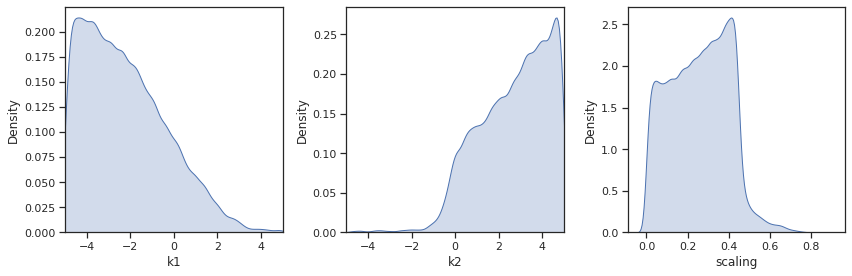

In [14]:
plt.figure(figsize=(12,4))
for n in range(len(problem.x_free_indices)):
    plt.subplot(1,3,n+1)
    sns.kdeplot(result.sample_result.trace_x[0, result.sample_result.burn_in:, problem.x_free_indices[n]],
                shade=True, color='C0')
    plt.xlabel(problem.x_names[problem.x_free_indices[n]])
    plt.xlim([problem.lb[problem.x_free_indices[n]], problem.ub[problem.x_free_indices[n]]])
plt.subplot(1,3,n+2)
ax = sns.kdeplot(scale_samples[:,0], shade=True, color='C0')
plt.xlabel('scaling')
plt.tight_layout()
plt.show()

In [15]:
plot_MAP = False

if plot_MAP:
    MAP_index = np.argmax(-result.sample_result.trace_neglogpost[0,result.sample_result.burn_in:])
    MAP = result.sample_result.trace_x[0,result.sample_result.burn_in+MAP_index,:]
    print(MAP)
    
    # experimental data
    data = np.asarray(dataframe.measurement)
    # time vector
    tvec = np.asarray(dataframe.time)

    tvec_for_simulation = np.linspace(tvec[0],tvec[-1],100)
    
    shape_MAP = MAP[-1]
    
    #changing scale to resampled values
    
    simulation = simulate_model(np.exp(MAP), tvec)

    scale = get_scale(data, simulation, shape_MAP, lamda)
    print(scale)

    # simulate model
    _simulation = np.asarray(simulate_model(np.exp(MAP), tvec_for_simulation))
    simulation_for_plotting = np.asarray(scale * _simulation)


    plt.figure()
    plt.plot(tvec,data,'or',label='Corrupted data')
    plt.plot(tvec_for_simulation,simulation_for_plotting,'k',label='MAP simulation')
    plt.xlabel('Time [a.u.]')
    plt.ylabel('Signal [a.u.]')
    #plt.ylim([0,2])
    plt.legend()
    plt.show()